<a href="https://colab.research.google.com/github/ad71/ragbot/blob/master/hierarchical_agent_teams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# each first-level agent node itself is a supervisor agent

In [2]:
%pip install -qU langchain langchain_openai langchain_community langchain_experimental langsmith matplotlib langgraph

In [3]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

# optional, add tracing in LangSmith
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'Multi-Agent Collaboration'

In [19]:
import json
import operator
import functools

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    HumanMessage,
    FunctionMessage
)

from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

from langchain_core.tools import tool
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain_experimental.tools import PythonREPLTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod

from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, END
from IPython.display import display, HTML, Image

from langsmith import trace

### Research team tools
The research team can use a search engine and a url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance.

In [8]:
tavily_tool = TavilySearchResults(max_results=5)

@tool
def scrape_webpages(urls: List[str]) -> str:
    '''Use requests and bs4 to scrape the provided webpages for detailed information'''
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return '\n\n'.join(
        [
            f'<Document name="{doc.metadata["title"]}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

### Document authoring team tools
We will give some tools for the doc writing team to use. We define some bare-bones file-access tools below
Note that this gives the agents access to your file-system, which can be unsafe.
We also haven't optimized the tool descriptions for performance.

In [10]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], 'List of main points or sections.'],
    file_name: Annotated[str, 'File path to save the outline.']
) -> Annotated[str, 'Path of the saved outline file.']:
    '''Create and save an outline'''
    with (WORKING_DIRECTORY / file_name).open('w') as file:
        for i, point in enumerate(points):
            file.write(f'{i + 1}. {point}\n')
    return f'Outline saved to {file_name}'

@tool
def read_document(
    file_name: Annotated[str, 'File path to save the document.'],
    start: Annotated[Optional[int], 'The start line. Default is 0'] = None,
    end: Annotated[Optional[int], 'The end line. Default is None'] = None
) -> str:
    '''Read the specified document'''
    with (WORKING_DIRECTORY / file_name).open('r') as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return '\n'.join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, 'Text content to be written into the document.'],
    file_name: Annotated[str, 'File path to save the document.'],
) -> Annotated[str, 'Path of the saved document file.']:
    '''Create and save a text document'''
    with (WORKING_DIRECTORY / file_name).open('w') as file:
        file.write(content)
    return f'Document saved to {file_name}'

@tool
def edit_document(
    file_name: Annotated[str, 'Path of the document to be edited.'],
    inserts: Annotated[
        Dict[int, str],
        'Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.'
    ]
) -> Annotated[str, 'Path of the edited document file.']:
    '''Edit a document by inserting text at specifid line numbers'''
    with (WORKING_DIRECTORY / file_name).open('r') as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + '\n')
        else:
            return f'Error: Line number {line_number} is out of range.'

    with (WORKING_DIRECTORY / file_name).open('w') as file:
        file.writelines(lines)

    return f'Document edited and saved to {file_name}'

repl = PythonREPLTool()
@tool
def python_repl(
    code: Annotated[str, 'The python code to execute to generate your chart.']
):
    '''Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.'''
    try:
        result = repl.run(code)
    except BaseException as e:
        return f'Failed to execute. Error: {repr(e)}'
    return f'Successfully executed:\n```python\n{code}\n```\nStdout: {result}'

## Helper utilities
We are going to create a few utility functions to make it more concise when we want to
1. Create a worker agent
2. Create a supervisor for the sub-graph

These will simplify the graph compositional code at the end for us to it's easier to see what's going on.

In [12]:
from typing import Any, Callable

from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str) -> str:
    '''Create a function calling agent and add it to the graph'''
    system_prompt += '\nWork autonomously according to your speciality, using the tools available to you.'
    'Do not ask for clarification. '
    'Your other team members (and other teams) will collaborate with you with their own specialities. '
    'You are chosen for a reason! You are one of the following team members: {team_members}.'
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                'system',
                system_prompt
            ),
            MessagesPlaceholder(variable_name='messages'),
            MessagesPlaceholder(variable_name='agent_scratchpad')
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {'messages': [HumanMessage(content=result['output'], name=name)]}

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    '''An LLM based router'''
    options = ['FINISH'] + members
    function_def = {
        'name': 'router',
        'description': 'Select the next role.',
        'parameters': {
            'title': 'routeSchema',
            'type': 'object',
            'properties': {
                'next': {
                    'title': 'next',
                    'anyOf': [
                        {'enum': options}
                    ]
                }
            },
            'required': ['next']
        }
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ('system', system_prompt),
            MessagesPlaceholder(variable_name='messages'),
            (
                'system',
                'Given the conversation above, who should act next? '
                'Or should we FINISH? Select one of: {options}'
            )
        ]
    ).partial(options=str(options), team_members=', '.join(members))
    return (prompt | llm.bind_functions(functions=[function_def], function_call='router') | JsonOutputFunctionsParser())

## Research Team
The research team will have a search agent and a web scraping "reseach_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [15]:
class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add] # a message is added after each team member finishes
    team_members: List[str] # the team members are tracked so they are aware of the others' skill-sets
    next: str # the supervisor calls a function that will update this every time it makes a decision

llm = ChatOpenAI(model='gpt-4-1106-preview')

search_agent = create_agent(llm, [tavily_tool], 'You are a research assistant who can search for up-to date info using the tavily search tool')
search_node = functools.partial(agent_node, agent=search_agent, name='Search')

research_agent = create_agent(llm, [scrape_webpages], 'You are a research assistant who can scrape specified urls for more detailed information')
research_node = functools.partial(agent_node, agent=research_agent, name='Web Scraper')

supervisor_agent = create_team_supervisor(
    llm=llm,
    system_prompt='You are a supervisor tasked with managing a conversation between the '
    'following workers: Search, Web Scraper. Given the following user request, '
    'respond with the worker to act next. Each worker will perform a '
    'task and respond with their results and status. When finished, '
    'respond with FINISH.',
    members=['Search', 'Web Scraper']
)

In [16]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node('Search', search_node)
research_graph.add_node('Web Scraper', research_node)
research_graph.add_node('supervisor', supervisor_agent)

research_graph.add_edge('Search', 'supervisor')
research_graph.add_edge('Web Scraper', 'supervisor')
research_graph.add_conditional_edges(
    'supervisor',
    lambda x: x['next'],
    {
        'Search': 'Search',
        'Web Scraper': 'Web Scraper',
        'FINISH': END
    }
)

research_graph.set_entry_point('supervisor')
chain = research_graph.compile()

# the following functions interoperate between the top level graph state and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        'messages': [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | chain

In [18]:
# we can use this directly
for s in research_chain.stream(
    'When is Taylor Swift\'s next tour?',
    {'recursion_limit': 100}):
    if '__end__' not in s:
        print(s)
        print('--------')

{'supervisor': {'next': 'Search'}}
--------
{'Search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour, known as "The Eras Tour," began in March 2023. After the initial U.S. tour dates, she is scheduled to kick off the 18-city Europe leg. Specific dates and further details about additional legs of the tour or any updates beyond what has been provided here would require checking official sources or tour announcements for the most current information.', name='Search')]}}
--------
{'supervisor': {'next': 'FINISH'}}
--------


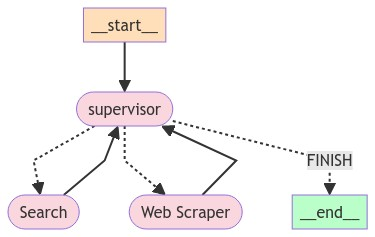

In [21]:
display(
    Image(
        chain.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

## Document Writing Team
File-system access is not safe in all cases

In [22]:
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

# this will be run before each worker agent begins work
# it makes it so they are more aware of the current state of the working directory

def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob('*')
        ]
    except:
        pass
    if not written_files:
        return {**state, 'current_files': 'No files written.'}
    return {
        **state,
        'current_files': '\nBelow are files your team has written to the directory:\n'
        + '\n'.join([f' - {f}' for f in written_files])
    }

llm = ChatOpenAI(model='gpt-4-1106-preview')

doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    'You are an expert writing a research document.\n'
    'Below are files currently in your directory:\n{current_files}'
)

# injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(agent_node, agent=context_aware_doc_writer_agent, name='Doc Writer')

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    'You are an expert senior researcher tasked with writing a paper outline and '
    'taking notes to craft a perfect paper. {current_files}'
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(agent_node, agent=context_aware_note_taking_agent, name='Note Taker')

chart_generating_agent = create_agent(
    llm,
    [read_document, python_repl],
    'You are a data viz expert tasked with generating charts for a research project. '
    '{current_files}'

)
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(agent_node, agent=context_aware_chart_generating_agent, name='Chart Generator')

doc_writing_supervisor = create_team_supervisor(
    llm,
    'You are a supervisor tasked with managing a conversation between the '
    'following workers: {team_members}. Given the following user request, '
    'respond with the worker to act next. Each worker will perform a '
    'task and respond with their results and status. When finished, '
    'respond with FINISH.',
    ['Doc Writer', 'Note Taker', 'Chart Generator']
)

In [23]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node('Doc Writer', doc_writing_node)
authoring_graph.add_node('Note Taker', note_taking_node)
authoring_graph.add_node('Chart Generator', chart_generating_node)
authoring_graph.add_node('supervisor', doc_writing_supervisor)

authoring_graph.add_edge('Doc Writer', 'supervisor')
authoring_graph.add_edge('Note Taker', 'supervisor')
authoring_graph.add_edge('Chart Generator', 'supervisor')

authoring_graph.add_conditional_edges(
    'supervisor',
    lambda x: x['next'],
    {
        'Doc Writer': 'Doc Writer',
        'Note Taker': 'Note Taker',
        'Chart Generator': 'Chart Generator',
        'FINISH': END
    }
)

authoring_graph.set_entry_point('supervisor')
chain = authoring_graph.compile()

def enter_chain(message: str, members: List[str]):
    results = {
        'messages': [HumanMessage(content=message)],
        'team_members': ', '.join(members)
    }
    return results

authoring_chain = functools.partial(enter_chain, members=authoring_graph.nodes) | chain

In [25]:
for s in authoring_chain.stream(
    'Write an outline for a poem and then write the poem to disk.',
    {'recursion_limit': 100}):
    if '__end__' not in s:
        print(s)
        print('--------')

{'supervisor': {'next': 'Note Taker'}}
--------
{'Note Taker': {'messages': [HumanMessage(content='The outline for the poem "Whispers of the Past" has been written and saved, along with the poem itself. The outline includes the following key points to structure the poem:\n\n1. Introduction to the theme\n2. Evocation of the past\n3. Interplay of memory and emotion\n4. Reflection on the passage of time\n5. Hope for the future intertwined with nostalgia\n6. Conclusion with a return to the present\n\nThe poem captures the essence of these points, weaving a tapestry of nostalgia and reflection through its verses.', name='Note Taker')]}}
--------


BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'messages[2].name': string does not match pattern. Expected a string that matches the pattern '^[a-zA-Z0-9_-]+$'.", 'type': 'invalid_request_error', 'param': 'messages[2].name', 'code': 'invalid_value'}}

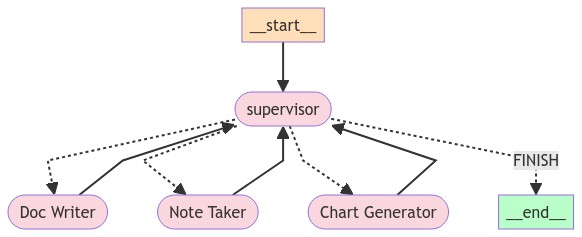

In [26]:
display(
    Image(
        chain.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)